In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

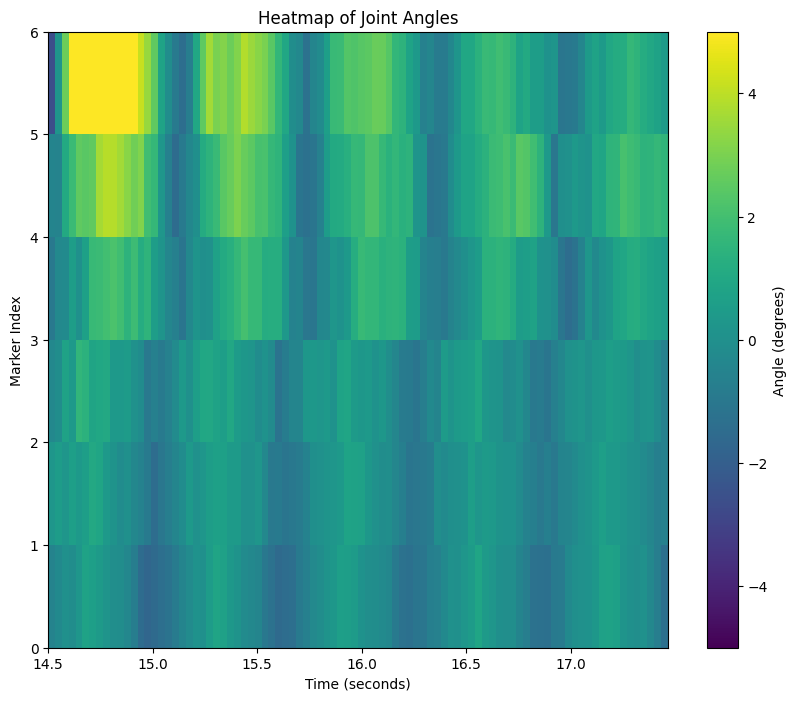

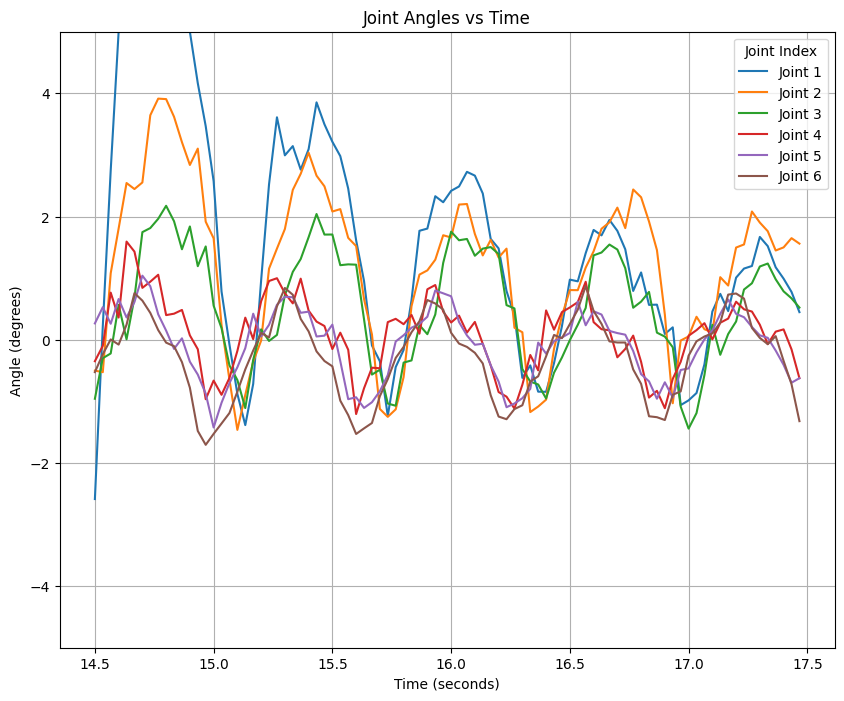

In [7]:
# Load the CSV file
file_path = '/Users/jamesxu/Desktop/swimming centipede/video_1DLC_resnet50_centi_swimSep5shuffle1_100000.csv'  
df = pd.read_csv(file_path)

# Extract the columns corresponding to the x and y coordinates for each marker
columns = df.iloc[1].tolist()  # Get the header row (contains 'x', 'y', 'likelihood')
coordinate_columns = [i for i, val in enumerate(columns) if val in ['x', 'y']]  # Only select x and y

# Now extract the relevant x, y coordinates into a new dataframe, skipping the first two rows as headers
coordinates_df = df.iloc[2:, coordinate_columns].astype(float)

# Limit to the first 20 seconds (600 frames)

frame_rate = 30 # REMEMBER TO CHANGE!

num_frames = 20 * frame_rate  # 20 seconds of data
coordinates_df = coordinates_df.head(num_frames)

# Define the time window
start_time = 14.5
end_time = 17.5

# Convert the time window to frames
start_frame = int(start_time * frame_rate)
end_frame = int(end_time * frame_rate)

# Extract the relevant frames for the time window
coordinates_df_window = coordinates_df.iloc[start_frame:end_frame]

# Calculate angles for the selected time window using every 3 consecutive markers (forming tangent angles)
angles_window = []

for i in range(len(coordinate_columns) // 2 - 2):  # Loop through triples of consecutive markers
    # Get the vectors from marker i to i+1 and i+1 to i+2
    vec1_x = coordinates_df_window.iloc[:, 2*i+1].values - coordinates_df_window.iloc[:, 2*i].values
    vec1_y = coordinates_df_window.iloc[:, 2*i+2].values - coordinates_df_window.iloc[:, 2*i+1].values
    vec2_x = coordinates_df_window.iloc[:, 2*i+3].values - coordinates_df_window.iloc[:, 2*i+2].values
    vec2_y = coordinates_df_window.iloc[:, 2*i+4].values - coordinates_df_window.iloc[:, 2*i+3].values
    
    # Compute the cross product to determine the sign of the angle
    cross_product = vec1_x * vec2_y - vec1_y * vec2_x
    
    # Compute the angles between the vectors using dot product and magnitude
    dot_product = vec1_x * vec2_x + vec1_y * vec2_y
    magnitude1 = np.sqrt(vec1_x**2 + vec1_y**2)
    magnitude2 = np.sqrt(vec2_x**2 + vec2_y**2)
    
    # Cosine of the angle
    cos_theta = dot_product / (magnitude1 * magnitude2)
    
    # Ensure no invalid values due to floating-point precision
    cos_theta = np.clip(cos_theta, -1, 1)
    
    # Calculate the angle in degrees
    angle = np.degrees(np.arccos(cos_theta))
    
    # Use the cross product to determine the sign of the angle
    angle = np.where(cross_product < 0, -angle, angle)
    
    # Make sure the angles are between -5° and 5°
    filtered_angle = np.clip(angle, -5, 5)
    
    angles_window.append(filtered_angle)

# Convert to a numpy array for easier manipulation
angles_window = np.array(angles_window)

# Time axis: convert frames to seconds
time_axis_window = np.arange(angles_window.shape[1]) / frame_rate + start_time

# Plot the heatmap for the selected time window
plt.figure(figsize=(10, 8))
plt.imshow(angles_window, aspect='auto', extent=[time_axis_window.min(), time_axis_window.max(), 0, angles_window.shape[0]])
plt.colorbar(label='Angle (degrees)')
plt.clim(-5, 5)
plt.xlabel('Time (seconds)')
plt.ylabel('Marker Index')
plt.title('Heatmap of Joint Angles')
plt.show()

# Plot the angles for all joints for the selected time window
plt.figure(figsize=(10, 8))

for i in range(angles_window.shape[0]):  # Loop through each joint's angles
    plt.plot(time_axis_window, angles_window[i], label=f'Joint {i+1}')

plt.xlabel('Time (seconds)')
plt.ylabel('Angle (degrees)')
plt.title('Joint Angles vs Time')
plt.ylim(-5, 5)
plt.grid(True)
plt.legend(title="Joint Index")
plt.show()
